# Uncertainty Quantification using Image Matching - Cylinder wake


## Description

Based on paper and source code:
 - Sciacchitano, A., Wieneke, B., & Scarano, F. (2013). PIV uncertainty quantification by image matching. *Measurement Science and Technology*, 24 (4). https://doi.org/10.1088/0957-0233/24/4/045302. 
 - http://piv.de/uncertainty/?page_id=221
 
*Step 1: Particle peak detection*

As described by (Sciacchitano et al., 2013, Eq. 1), the image intensity product $\Pi$ from image matching intensities is defined as:
$$
\Pi = \hat{I}_1\hat{I}_2
$$
The peaks image $\varphi$ is defined as:
$$
\varphi(i,j) = \begin{cases}
1\quad\text{if }\Pi(i,j)\text{ is a relative maximum} \\
0\quad\text{otherwise}
\end{cases}
$$

*Step 2: Disparity vector computation*

The sub-pixel peak position estimator adopted here is the standard 3-point Gaussian fit. The particle positions of times $t_1$ and $t_2$ are 
defined as $\boldsymbol{X}^1 = \{x^1_1,x^1_2,...,x^1_N\}$ and $\boldsymbol{X}^2 = \{x^2_1,x^2_2,...,x^2_N\}$. Discrete disparity vectors are defined as:
$$
\boldsymbol{D} = \boldsymbol{X}^2 - \boldsymbol{X}^1
$$


## Setup

**Packages**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

**Load images**

In [52]:
parent_path = "./data/particledisparity_code_testdata/"
image_pair = np.array(
    [
        plt.imread(os.path.join(parent_path + ipath)).astype("float")
        for ipath in ["B00010.tif", "B00011.tif"]
    ]
)

**Load reference velocity**

In [53]:
data = np.loadtxt(os.path.join(parent_path + "B00010_UQ.dat"), skiprows=3).T

I, J = 128, 128
X_ref = np.reshape(data[0], (I, J)) - 1  # zero-index
Y_ref = np.reshape(data[1], (I, J)) - 1
U_ref = np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J))))
e_ref = np.stack((np.reshape(data[4], (I, J)), np.reshape(data[5], (I, J))))
N_ref = np.reshape(data[6], (I, J))

window_size = X_ref[0][1] - X_ref[0][0]

In [66]:
# %%time
# warped_image_pair = pivuq.warp(
#     image_pair,
#     U_ref,
#     velocity_upsample_kind="linear",
#     direction="center",
#     nsteps=1,
#     order=1,
# )

# %%time
# radius = 1
# D, c, peaks = pivuq.lib.disparity_vector_computation(
#     warped_image_pair, threshold_ratio=1, radius=radius, sigma=None
# )

# coords = np.stack(np.where(peaks))

# %%time
# N, mu, sigma, delta = pivuq.lib.disparity_statistics(D, c, window_size=16, window="gaussian")

CPU times: user 29 ms, sys: 874 µs, total: 29.8 ms
Wall time: 29.4 ms


CPU times: user 30.4 ms, sys: 9 µs, total: 30.4 ms
Wall time: 30.1 ms


## Uncertainity quantificiation using image matching

In [230]:
%%time
X, Y, delta, N, mu, sigma = pivuq.disparity.sws(
    image_pair,
    U_ref,
    window_size=16,
    window="gaussian",
    threshold_ratio=1,
    radius=2,
    sigma=None,
    sliding_window_subtraction=True,
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=1,
    warp_nsteps=5,
)

CPU times: user 4.85 s, sys: 6.1 ms, total: 4.85 s
Wall time: 426 ms


## Plot: Disparity statistics

[Text(0.5, 1.0, '$|\\delta|$')]

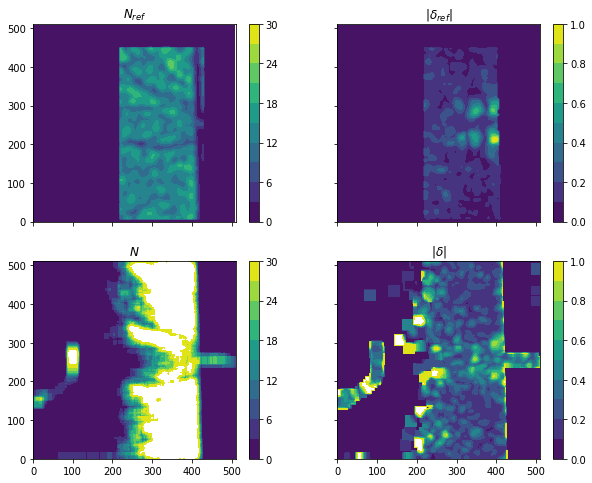

In [231]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8))

ax = axes[0, 0]
im = ax.contourf(X_ref, Y_ref, N_ref, np.linspace(0, 30, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$N_{ref}$")

ax = axes[0, 1]
im = ax.contourf(X_ref, Y_ref, np.linalg.norm(e_ref, axis=0), np.linspace(0, 1, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{ref}|$")

ax = axes[1, 0]
im = ax.contourf(X, Y, N, np.linspace(0, 30, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$N$")

ax = axes[1, 1]
im = ax.contourf(X, Y, np.linalg.norm(delta, axis=0), np.linspace(0, 1, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta|$")

## Plot: Disparity histogram

In [83]:
# fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(15, 3))

# for i, (ax, label) in enumerate(zip(axes[:2], [r"$\delta_x$ (px)", r"$\delta_y$ (px)"])):
#     ax.hist(delta[i].ravel(), bins=50, density=True)
#     ax.set(title=label)

# ax = axes[-1]
# ax.hist(np.linalg.norm(delta, axis=0).ravel(), bins=50, density=True)
# ax.set(title="$|\delta|$ (px)");